In [1]:
import pathlib as pl
from configparser import ConfigParser
import itertools as itt

import joblib as jl
import numpy as np
import scipy.stats as sst
from scikit_posthocs import posthoc_dunn
import scipy.signal as snl
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from nems import db as nd
from nems_lbhb.baphy_experiment import BAPHYExperiment

from src.visualization.palette import *
from src.data.cell_type import get_optotag_DF
from src.root_path import config_path, root_path

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)


[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-12-14 152637.log


Code copied over from "220816_cell_type_ctx_modulation.ipynb" and cleaned

# Load cell descriptions
containing ID, phototag, and spike wave form parameters

In [11]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '220816_CPN_celltype_DF'
toclust = jl.load(type_DF_file).dropna(subset='sw')
print(toclust.shape)
toclust['siteid'] = toclust['id'].str.split('-').str[0]

# refresh phototags
pt = get_optotag_DF()
pt.rename(columns={'cellid': 'id'}, inplace=True)
toclust.drop(columns=['phototag'], inplace=True)
toclust = pd.merge(toclust, pt, on=['siteid', 'id'], validate="1:1", how='left')

# just activated
toclust['phototag3'] = toclust['phototag'].astype(object)
toclust.phototag3.replace({'a': True, 'n': False, 's': False}, inplace=True)
toclust.loc[toclust.phototag3.isnull(), 'phototag3'] = False
toclust['phototag3'] = toclust['phototag3'].astype(bool)

#classify which neurons were injected
toclust['injected'] = ~pd.isnull(toclust.phototag)

print(toclust.shape)
print(toclust.groupby(['phototag3']).agg(cell_count=('id', 'count')))

(1630, 12)
(1630, 15)
           cell_count
phototag2            
a                  51
n+s               885
untagged          694
           cell_count
phototag3            
False            1579
True               51


# spike width classification

The photo tagged units are restricted to narrow waveforms, whereas they are spread across all other categories.
Let just define categories based on spike waveforms

clear bimodal distrubution, just find the valley in the KDE and define a margin around it

waveform threshold. lower: 0.37, upper 0.47


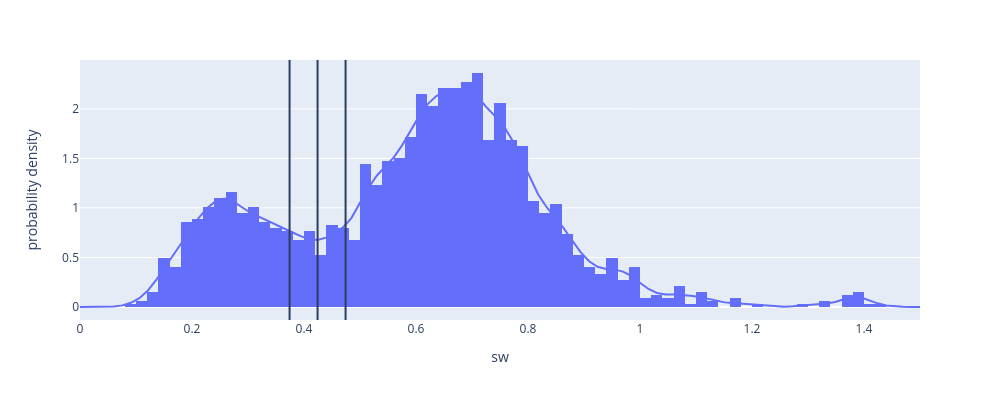

In [12]:
# define kernel density estimate, the bandwidth is defined empirically
kernel = sst.gaussian_kde(toclust.loc[~toclust.sw.isnull(), 'sw'], 0.1)
x = np.linspace(0, 1.5, 100)
hist = kernel(x)

# find valley in bimodal distribution
min_idx = snl.argrelmin(hist)[0]
# print(x[min_idx])
hist_threshold = x[min_idx[0]]
margin = 0.05  # plus or minus in ms
print(f'waveform threshold. lower: {hist_threshold - margin:.2f}, upper {hist_threshold + margin:.2f}')

# Classifies base on valley plus an unclasified zone of 0.1ms
named_labels = np.empty(len(toclust['sw']), dtype=object)
named_labels[toclust['sw'] < (hist_threshold - margin)] = 'narrow'
named_labels[np.logical_and((hist_threshold - margin) <= toclust['sw'],
                            (toclust['sw'] < (hist_threshold + margin)))] = 'unclass'
named_labels[(hist_threshold + margin) <= toclust['sw']] = 'broad'

toclust['sw_kde'] = named_labels

# plot KDE on top of histogram
KDE_line = px.line(x=x, y=hist)
fig = px.histogram(toclust, x='sw', nbins=100, histnorm='probability density')
fig.add_traces(KDE_line['data'])
fig.add_vline(x=hist_threshold)
fig.add_vline(x=hist_threshold - margin)
fig.add_vline(x=hist_threshold + margin)

fig.show(renderer='jpeg')


### Triple classification
Focus on narrow vs broad, pulling out the third clasiffication: activated, as a confirmation of narrow

In [14]:
triple = np.empty(toclust.shape[0], dtype=object)
activated = toclust.phototag == 'a'
narrow = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'narrow')
broad = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'broad')
unclass = np.logical_and(~toclust.phototag3, toclust.sw_kde == 'unclass')

triple[toclust.phototag3] = 'activated'
triple[narrow] = 'narrow'
triple[broad] = 'broad'
triple[unclass] = 'unclass'

toclust['triple'] = pd.Series(triple, dtype='category')

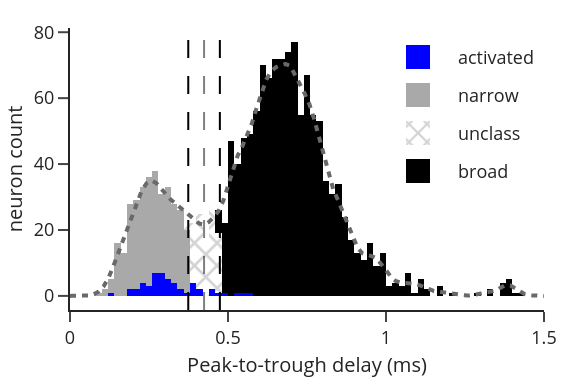

In [16]:
fig = px.histogram(toclust.dropna(subset=['triple']), nbins=100,
                   x='sw', color='triple',
                   pattern_shape='triple',
                   pattern_shape_map={'activated': "", 'narrow': "", "unclass": "x", "broad": ""},
                   barmode='stack',
                   color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', "unclass": 'lightgray',
                                       "broad": 'black'},
                   category_orders={'triple': ['activated', 'narrow', 'unclass', 'broad']},
                   )
fig.update_traces(marker_line_width=0)
# this scaling is a hardcoded hack defined by vidually comparing with the figure above where the historgrams are also a probability density
kernel = sst.gaussian_kde(toclust['sw'], 0.1)
x = np.linspace(0, 1.5, 100)
y = kernel(x) * 32
fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='dimgray', dash='dot'), showlegend=False))
fig.add_vline(x=hist_threshold, line=dict(color='black', dash='dash', width=1), opacity=0.5)
fig.add_vline(x=hist_threshold - margin, line=dict(color='black', dash='dash', width=1), opacity=1)
fig.add_vline(x=hist_threshold + margin, line=dict(color='black', dash='dash', width=1), opacity=1)

w, h = 3, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  bargap=0,
                  xaxis=dict(title=dict(standoff=0,
                                        text='Peak-to-trough delay (ms)',
                                        font_size=10),
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='neuron count',
                                        standoff=0,
                                        font_size=10),
                             tickfont_size=9),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

filename = folder / 'fig5_cell_type_histogram'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

In [17]:
toclust.groupby('triple').agg(count=('id', pd.Series.nunique))

,count
triple,
activated,51
broad,1172
narrow,301
unclass,106


# mean of  waveforms for different categories

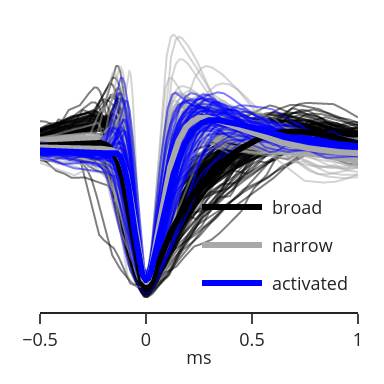

In [70]:
def get_aligned_waveforms(DF):
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])
        centered.append(wave)

    centered = np.stack(centered, axis=0)

    return centered, time


fig = go.Figure()
PHOTOACT = HardBlue
for clss, color in zip(['broad', 'narrow', 'activated'], [Black, DarkGray, PHOTOACT]):
    lines, t = get_aligned_waveforms(toclust.query(f"triple == '{clss}'"))

    # Single waveform examples, decimated,
    decimate = 150
    if lines.shape[0] >= decimate:
        decimator = np.random.choice(lines.shape[0], decimate, replace=False)
        mlines = lines[decimator, :]
    else:
        mlines = lines

    for line in mlines:
        _ = fig.add_trace(
            go.Scatter(x=t, y=line, mode='lines',
                       line=dict(
                           color=add_opacity(color, 1),
                           # color=color,
                           width=1),
                       opacity=0.5,
                       showlegend=False))

# Average for the group, have to do it second so they are on top
for clss, color in zip(['broad', 'narrow', 'activated'], [Black, DarkGray, HardBlue]):
    lines, t = get_aligned_waveforms(toclust.query(f"triple == '{clss}'"))
    _ = fig.add_trace(
        go.Scatter(x=t, y=lines.mean(axis=0), mode='lines',
                   line=dict(color=color, width=3),
                   name=clss))

#formating
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  xaxis=dict(title=dict(standoff=0,
                                        text='ms',
                                        font_size=9
                                        ),
                             # showticklabels=False,
                             # showline=False,
                             # ticks='',
                             tickfont_size=9),
                  yaxis=dict(title=dict(text='',

                                        standoff=0,
                                        ),
                             showticklabels=False,
                             showline=False,
                             ticks='',
                             tickfont_size=9),
                  showlegend=True,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0,
                              font_size=9,
                              title_text='',
                              bgcolor="rgba(0,0,0,0)"),
                  )

filename = folder / 'fig5_waveformsd'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

# Example neuron phototagged raster

In [24]:
# to allow longer trials with short pulses, sub in  Trial_LightPulseDuration for Ref_Duration
cellid = 'TNC013a-031-4'
expt_n = 1  # which of the phototag experiments to use
# data time offsets in ms? relative to light on
tstart = -0.02
tend = 0.1

rasterfs = 5000

# find the raw files in the database
df = nd.pd_query("SELECT sCellFile.cellid, sCellFile.stimfile, sCellFile.stimpath, sCellFile.rawid,"
                 "g2.value as Ref_Duration FROM sCellFile "
                 "INNER JOIN gData ON gData.rawid=sCellFile.rawid AND gData.name='TrialObjectClass' "
                 "INNER JOIN gData g2 ON g2.rawid=sCellFile.rawid AND g2.name='Ref_Duration' "
                 "WHERE gData.svalue='RefTarOpt' AND g2.value<0.1 AND sCellFile.RunClassid = 51 "
                 f"AND sCellFile.cellid='{cellid}'")  # change this cellid as needed

# clean up DF
df['siteid'] = df.cellid.apply(nd.get_siteid)
df['recording'] = df.stimfile.str.split('.').str[0]
df['parmfile'] = df.stimpath + df.stimfile  # full path to parameter file.
df.drop(columns=['stimfile'], inplace=True)

print(df)

# select just one of multiple phototag experiments for the neuron
paramfile, rawid = df.loc[:, ('parmfile', 'rawid')].iloc[expt_n, :]
manager = BAPHYExperiment(parmfile=paramfile, rawid=rawid,
                          cellid=cellid)

rec = manager.get_recording(recache=True, resp=True, rasterfs=rasterfs, stim=False)
rec['resp'] = rec['resp'].rasterize()
prestim = rec['resp'].extract_epoch('PreStimSilence').shape[-1] / rasterfs

# get light on / off
opt_data = rec['resp'].epoch_to_signal('LIGHTON')
opto_mask = opt_data.extract_epoch('REFERENCE').any(axis=(1, 2))

opt_start_stop_bins = np.argwhere(
    np.diff(opt_data.extract_epoch('REFERENCE')[opto_mask, :, :][0, 0, :])).squeeze() + 1
opt_duration = np.diff(opt_start_stop_bins)[0] / rasterfs

rec_cellids = np.asarray(rec['resp'].chans)

# get only the relevant part of the raster, using the light onset time as an anchor point
start_time = prestim + tstart
end_time = prestim + tend
start_bin = np.floor(start_time * rasterfs).astype(int)
end_bin = np.floor(end_time * rasterfs).astype(int)

raw_raster = rec['resp'].extract_epoch('REFERENCE')[:, :, start_bin:end_bin]

ON = raw_raster[opto_mask, 0, :]
OFF = raw_raster[~opto_mask, 0, :]

t = np.linspace(tstart, tend, end_bin - start_bin, endpoint=False) * 1000  # in ms

          cellid                           stimpath   rawid  Ref_Duration  \
0  TNC013a-031-4  /auto/data/daq/Teonancatl/TNC013/  143892          0.02   
1  TNC013a-031-4  /auto/data/daq/Teonancatl/TNC013/  143891          0.02   
2  TNC013a-031-4  /auto/data/daq/Teonancatl/TNC013/  143890          0.02   

    siteid        recording                                           parmfile  
0  TNC013a  TNC013a12_p_NON  /auto/data/daq/Teonancatl/TNC013/TNC013a12_p_N...  
1  TNC013a  TNC013a11_p_NON  /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_N...  
2  TNC013a  TNC013a10_p_NON  /auto/data/daq/Teonancatl/TNC013/TNC013a10_p_N...  


[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 120 trials totaling 203.39 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC013/TNC013a11_p_NON.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbh

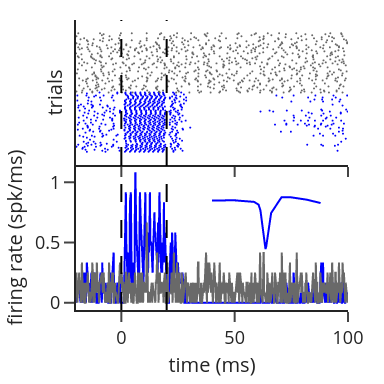

In [25]:
fig = make_subplots(3, 1)

for oo, (arr, color) in enumerate(zip([ON, OFF], [PHOTOACT, '#696969'])):
    # spike raster / light onset/offset
    yoffset = (ON.shape[0] - 1) * oo
    st = np.where(arr)
    x = ((st[1] / rasterfs) + tstart) * 1000
    # _ = axes[0].scatter(x, st[0], s=1, color='blue')
    _ = fig.add_trace(go.Scatter(x=x, y=st[0] + yoffset, mode='markers',
                                 marker=dict(color=color, size=1)),
                      row=1, col=1)

    # psth
    y = arr.mean(axis=0) * rasterfs / 1000
    yerr = arr.std(axis=0) / arr.shape[0] * rasterfs
    _ = fig.add_trace(go.Scatter(x=t, y=y, mode='lines', line=dict(color=color, width=1)),
                      row=2, col=1)  # last row so it keeps the x axis

# inset of waveform
mean_waveform = toclust.query(f"id == '{cellid}'").waveform_norm.values[0]
x = np.linspace(t[0], t[-1], len(mean_waveform))  # hack to share axes
_ = fig.add_trace(go.Scatter(x=x, y=mean_waveform,
                             mode='lines',
                             line=dict(color=PHOTOACT, width=1)), row=3, col=1)

for row in [1, 2]:
    for vline in [0, opt_duration * 1000]:
        fig.add_vline(x=vline, line=dict(width=1, dash='dash', color='black'), opacity=1, row=row, col=1)

# format
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  xaxis=dict(matches='x2', autorange=False,
                             showticklabels=False, ),
                  yaxis=dict(title=dict(standoff=0,
                                        text='trials',
                                        font_size=10
                                        ),
                             domain=[0.5, 1],
                             showticklabels=False,
                             ticks='',
                             tickfont_size=9),

                  xaxis2=dict(title=dict(standoff=0,
                                         text='time (ms)',
                                         font_size=10
                                         ),
                              range=[-20, 100],
                              tickfont_size=9),
                  yaxis2=dict(title=dict(text='firing rate (spk/ms)',
                                         font_size=10,
                                         standoff=0,
                                         ),
                              domain=[0, 0.5],
                              tickfont_size=9),

                  # inset
                  xaxis3=dict(matches=None,
                              showticklabels=False,
                              ticks='',
                              showline=False,
                              domain=[0.5, 0.9]),
                  yaxis3=dict(showticklabels=False,
                              ticks='',
                              showline=False,
                              domain=[0.2, 0.4]),

                  showlegend=False,
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0,
                              font_size=9,
                              title_text='',
                              bgcolor="rgba(0,0,0,0)"),
                  )

filename = folder / 'fig5_eg_phototag'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

# cell type differences
check differences in amplitude, durationc and context coverage for the three classifications of neurons

In [33]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
metrics = ['integral', 'last_bin', 'integral_nosig']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} "
                                    f"and cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' "
                                    f"and analysis == 'SC' "
                                    )

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', ], inplace=True)
DF['metric'] = DF.metric.cat.remove_unused_categories()
DF.reset_index(drop=True, inplace=True)

# use the integrale value to find instances that are significant, and a new significance column
signif_filter = DF.query("metric == 'integral' and value > 0").loc[:, ['id', 'context_pair', 'probe']].copy()
signif_filter['significant'] = True

DF = pd.merge(DF, signif_filter, on=['id', 'context_pair', 'probe'], how='left', validate='m:1')
DF.loc[DF.significant.isnull(), 'significant'] = False
DF['significant'] = DF.significant.astype(bool)

for col in ['id', 'context_pair', 'probe', 'site', 'region', 'metric', 'stim_count']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
normalizer = DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value', np.mean)).reset_index()

DF = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
DF['norm_val'] = DF['value'] / DF['grand_mean']
DF.drop(columns=['grand_mean'], inplace=True)

# add celltype labels
toregress = pd.merge(DF,
                     toclust,
                     on='id', validate="m:1").reset_index(drop=True)

print(toregress.shape)
toregress.head()

(1438200, 27)


,id,context_pair,probe,value,metric,site,region,stim_count,significant,norm_val,...,isolation,spike_type,siteid,phototag,phototag2,phototag3,injected,sw_kde,putative,triple
0,ARM019a-03-6,00_01,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
1,ARM019a-03-6,00_02,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
2,ARM019a-03-6,00_03,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
3,ARM019a-03-6,00_04,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad
4,ARM019a-03-6,01_02,1,0.0,integral,ARM019a,PEG,4,False,0.0,...,95.3824,broad,ARM019a,NaN,untagged,False,False,broad,pyramidal,broad


In [36]:
def all_pairwise_comparison(df, group_col, val_col, statfn):
    stats_df = list()
    for c0, c1 in itt.combinations(df[group_col].unique(), r=2):
        x = df.query(f"{group_col} == '{c0}'")[val_col]
        y = df.query(f"{group_col} == '{c1}'")[val_col]
        stout = statfn(x, y)
        stats_df.append(dict(metric=met, class0=c0, class1=c1,
                             mean0=np.mean(x), mean1=np.mean(y),
                             median0=np.median(x), median1=np.median(y),
                             quant0=np.quantile(x, 0.75), quant1=np.quantile(y, 0.75),
                             pvalue=stout.pvalue))

    stats_df = pd.DataFrame(stats_df).set_index(['metric', 'class0', 'class1'])
    stats_df['corr_pvalue'] = stats_df['pvalue'] * 3
    stats_df['0.05'] = stats_df['corr_pvalue'] < 0.05
    stats_df['0.01'] = stats_df['corr_pvalue'] < 0.01
    stats_df['0.001'] = stats_df['corr_pvalue'] < 0.001
    print(stats_df)
    return stats_df


def kruskal_with_posthoc(df, group_col, val_col):
    # pools data in a list of vectors to run kruskal
    to_stat = list()
    for kk in df[group_col].unique():
        to_stat.append(df.loc[df[group_col] == kk, val_col].values)
    kruskal = sst.kruskal(*to_stat)
    print(kruskal)

    # uses the og dataframe to run the pairwise posthoc test
    dunn = posthoc_dunn(df, val_col=val_col, group_col=group_col, p_adjust='bonferroni')
    print(f'Dunn post hoc results\n{dunn}')

    return kruskal, dunn


def jknf(x, njacks=20, fn=np.mean):
    pred = x
    chunksize = int(np.ceil(len(pred) / njacks / 10))
    chunkcount = int(np.ceil(len(pred) / chunksize / njacks))
    idx = np.zeros((chunkcount, njacks, chunksize))
    for jj in range(njacks):
        idx[:, jj, :] = jj
    idx = np.reshape(idx, [-1])[:len(pred)]
    jc = np.zeros(njacks)
    for jj in range(njacks):
        ff = (idx != jj)
        jc[jj] = fn(pred[ff])

    stat = np.nanmean(jc)
    error = np.nanstd(jc) * np.sqrt(njacks - 1)

    return stat, error



######## integral ########
KruskalResult(statistic=63.20672466613851, pvalue=1.8829298015101073e-14)
Dunn post hoc results
           activated         broad        narrow
activated   1.000000  1.059118e-06  1.314109e-01
broad       0.000001  1.000000e+00  1.786963e-10
narrow      0.131411  1.786963e-10  1.000000e+00

######## last_bin ########
KruskalResult(statistic=30.27459544161709, pvalue=2.6665831403429457e-07)
Dunn post hoc results
           activated         broad        narrow
activated   1.000000  2.219481e-01  1.000000e+00
broad       0.221948  1.000000e+00  2.704322e-07
narrow      1.000000  2.704322e-07  1.000000e+00


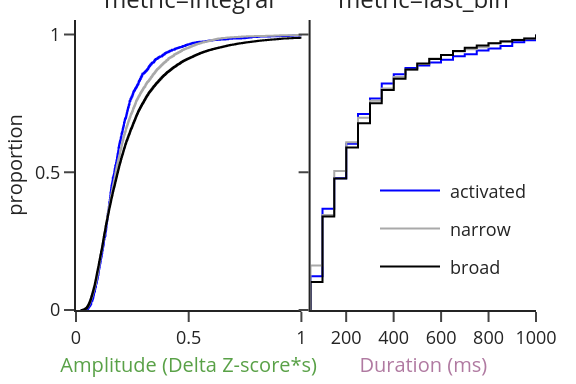

In [37]:
categories = ['activated', 'narrow', 'broad']
toplot = toregress.query(f"triple in {categories} "
                         "and metric in ['integral', 'last_bin']"
                         "and significant"
                         ).copy()

# integral in seconds instead of ms
toplot.loc[toplot.metric == 'integral', 'value'] = toplot.loc[toplot.metric == 'integral', 'value'] / 1000

toplot['triple'] = toplot.triple.cat.remove_unused_categories()

fig = px.ecdf(toplot,
              x='value', color='triple', facet_col='metric',
              color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 3, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0, 1],
                             title=dict(text='Amplitude (Delta Z-score*s)',
                                        font_color=AMPCOLOR)),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),
                  xaxis2=dict(matches=None, autorange=True,
                              title=dict(text='Duration (ms)',
                                         font_color=DURCOLOR)),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

#stats
for met in toplot.metric.unique():
    print(f"\n######## {met} ########")
    _ = kruskal_with_posthoc(toplot.query(f"metric == '{met}'"), group_col='triple', val_col='value')

filename = folder / 'fig5_context_effect_by_celltype'
fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

In [38]:
toplot.groupby(['metric', 'triple']).agg(count=('value', 'count'), mean=('value', 'mean'))

count        mean
metric         triple                      
integral       activated   1401    0.204019
               broad      32528    0.245317
               narrow      8244    0.214651
integral_nosig activated      0         NaN
               broad          0         NaN
               narrow         0         NaN
last_bin       activated   1401  252.426834
               broad      32528  252.908264
               narrow      8244  246.015289


#### integral ####
             median  SEmedian      mean    SEmean
triple                                           
activated  0.169934  0.005676  0.204019  0.003552
narrow     0.176161  0.002491  0.214651  0.001481
broad      0.185344  0.001026  0.245317  0.001788

#### last_bin ####
           median  SEmedian        mean    SEmean
triple                                           
activated   200.0       0.0  252.426840  5.767985
narrow      150.0       0.0  246.015284  2.032029
broad       200.0       0.0  252.908264  1.833654


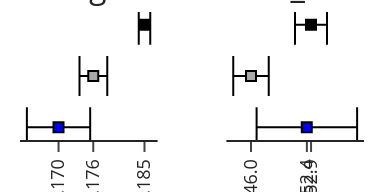

In [39]:
# add someting along the line of means and SEMs
summary = toplot.groupby(['metric', 'triple']).agg(
    median=('value', lambda x: jknf(x, 1000, np.nanmedian)[0]),
    SEmedian=('value', lambda x: jknf(x, 1000, np.nanmedian)[1]),
    mean=('value', lambda x: jknf(x, 1000, np.nanmean)[0]),
    SEmean=('value', lambda x: jknf(x, 1000, np.nanmean)[1]),
)

metrics = ['integral', 'last_bin']
fig = make_subplots(1, 2, horizontal_spacing=0.2, subplot_titles=metrics)
for cc, met in enumerate(metrics):
    met_df = summary.loc[(met), :].reindex(index=['activated', 'narrow', 'broad'])
    print(f"\n#### {met} ####\n{met_df}")
    if met == 'integral':
        stat = met_df['median'].values
        err = met_df['SEmedian'].values
        ticktext = [f'{m:.3f}' for m in stat]
    elif met == 'last_bin':
        stat = met_df['mean'].values
        err = met_df['SEmean'].values
        ticktext = [f'{m:.1f}' for m in stat]
    names = met_df.index.tolist()
    # added line to this single call, make sure it actually works
    fig.add_trace(go.Scatter(x=stat, y=names,
                             mode='markers',
                             opacity=1,
                             showlegend=False,
                             marker=dict(color=[PHOTOACT, DarkGray, Black],
                                         symbol='square',
                                         size=5,
                                         line=dict(color='black',
                                                   width=1)
                                         ),
                             error_x=dict(array=err,
                                          color='black',
                                          thickness=1,
                                          width=10
                                          ),
                             ), row=1, col=cc + 1)
    fig.update_xaxes(tickmode='array',
                     tickvals=stat,
                     ticktext=ticktext,
                     tickangle=-90,
                     row=1, col=cc + 1)

# formating
w, h = 2, 1
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False, )

# commong features of both x axes
fig.update_yaxes(showticklabels=False, ticks='', showline=False,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

fig.update_xaxes(showticklabels=True, ticks='outside', showline=True,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_ctx_effect_inset'
fig.write_image(filename.with_suffix('.svg'))

fig.showe(renderer='jpeg', scale=2)

# check proportion
what number of significant instances per category? is there a greater likelyhood of showing contextual
effects for inhibitory or pyramidal neurons?


####### non parametric anova with posthoc #######
KruskalResult(statistic=7.41797435090606, pvalue=0.02450232726699855)
Dunn post hoc results
           activated     broad    narrow
activated   1.000000  1.000000  0.235344
broad       1.000000  1.000000  0.022503
narrow      0.235344  0.022503  1.000000


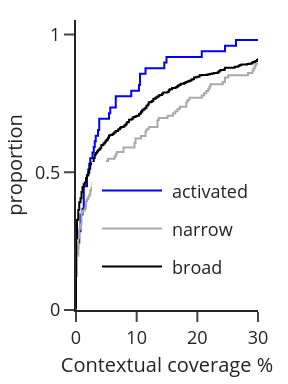

In [47]:
coverage_prop = toregress.query(
    "triple in ['activated', 'narrow', 'broad'] "
    "and metric == 'integral' "
    "and stim_count in [10]"  # only select this subsets as is the one containing the optotagged neurons
).groupby(
    ['triple', 'id'], observed=True
).agg(
    coverage=('significant', lambda x: sum(x) / len(x) * 100),
    count=('significant', 'count')
).reset_index()

# midpoint statistics
# print("\n####### all pairwise ranksum #######")
# _ = all_pairwise_comparison(coverage_prop, 'triple', 'coverage', sst.ranksums)

print("\n####### non parametric anova with posthoc #######")
_ = kruskal_with_posthoc(coverage_prop, 'triple', 'coverage')

fig = px.ecdf(coverage_prop,
              x='coverage', color='triple',
              color_discrete_map={'activated': HardBlue, 'narrow': 'darkgray', 'broad': 'black'},
              category_orders={'triple': ['activated', 'narrow', 'broad'],
                               },
              render_mode='svg')
_ = fig.update_traces(line_width=1)

# formating
w, h = 1.5, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  legend=dict(xanchor='right', x=1,
                              yanchor='bottom', y=0.05,
                              font_size=9,
                              title=dict(text='')),
                  xaxis=dict(matches=None, autorange=False,
                             range=[0, 30],
                             title=dict(text='Contextual coverage %')),
                  yaxis=dict(title=dict(text='proportion', font_size=10, standoff=0),
                             tickfont_size=9),

                  )
# commong features of both x axes
fig.update_xaxes(title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_coverage_by_celltype'
fig.write_image(filename.with_suffix('.svg'))

fig.showe(renderer='jpeg', scale=2)


##### bar values #####
           coverage     error
triple                       
activated  2.000000  0.626680
narrow     3.916364  1.105458
broad      2.148182  0.595277


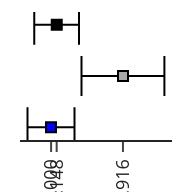

In [48]:
coverage_summary = coverage_prop.groupby(
    ['triple'], observed=True
).agg(
    coverage=('coverage', lambda x: jknf(x, 100, np.median)[0]),
    error=('coverage', lambda x: jknf(x, 100, np.median)[1]),
).reindex(index=['activated', 'narrow', 'broad'])

print(f"\n##### bar values #####\n{coverage_summary}")

fig = go.Figure()

stat = coverage_summary['coverage'].values
err = coverage_summary['error'].values
names = coverage_summary.index.tolist()
# added line to this single call, make sure it actually works
fig.add_trace(go.Scatter(x=stat, y=names,
                         mode='markers',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color=[PHOTOACT, DarkGray, Black],
                                     symbol='square',
                                     size=5,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_x=dict(array=err,
                                      color='black',
                                      thickness=1,
                                      width=10
                                      ),
                         ))

fig.update_xaxes(tickmode='array',
                 tickvals=stat,
                 ticktext=[f'{m:.3f}' for m in stat],
                 tickangle=-90
                 )

# formating
w, h = 1, 1
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(t=10, b=10, l=10, r=10),
                  showlegend=False, )

# commong features of both x axes
fig.update_yaxes(showticklabels=False, ticks='', showline=False,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

fig.update_xaxes(showticklabels=True, ticks='outside', showline=True,
                 title=dict(font_size=10, standoff=0), tickfont_size=9)

filename = folder / 'fig5_coverage_inset'
fig.write_image(filename.with_suffix('.svg'))

fig.showe(renderer='jpeg', scale=2)